# Bike Sharing Demand Competition on Kaggle

https://www.kaggle.com/c/bike-sharing-demand

Before using this script register yourself to Kaggle and get the data. Files `train.csv` and `test.csv` should be located in the same folder.

In [1]:
import csv

data = []
with open('train.csv') as fin:
    reader = csv.reader(fin, delimiter=',')
    next(reader, None)
    for row in reader:
        data.append(row)

In [2]:
train_features = []
train_labels = []

from dateutil import parser
import calendar


for item in data:
    features = []
    time = parser.parse(item[0])
    
    seconds_after_midnight = (time - time.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    hours_after_midnight = seconds_after_midnight // 3600
    day_of_week = time.weekday()
    
    features = features + [hours_after_midnight, day_of_week]
    features = features + [float(x) for x in item[1:9]]
    train_features.append(features)
    train_labels.append(int(item[-1]))

print train_features[0], len(train_features[0])

[0.0, 5, 1.0, 0.0, 0.0, 1.0, 9.84, 14.395, 81.0, 0.0] 10


In [3]:
# train data analysis
import numpy as np

for i in range(len(train_features[0])):
    mean = np.array([x[i] for x in train_features]).mean()
    std = np.array([x[i] for x in train_features]).std()
    print 'Col', i, mean, std

print 'Label', np.array(train_labels).mean(), np.array(train_labels).std()

Col 0 11.541613081 6.91552031364
Col 1 3.01396288811 2.00449333667
Col 2 2.50661399963 1.11612304166
Col 3 0.0285688039684 0.166591198472
Col 4 0.680874517729 0.46613775736
Col 5 1.41842733787 0.633809472594
Col 6 20.23085982 7.79123196374
Col 7 23.6550840529 8.47421137445
Col 8 61.886459673 19.2441493221
Col 9 12.7993954069 8.16416231651
Label 191.574131913 181.136133574


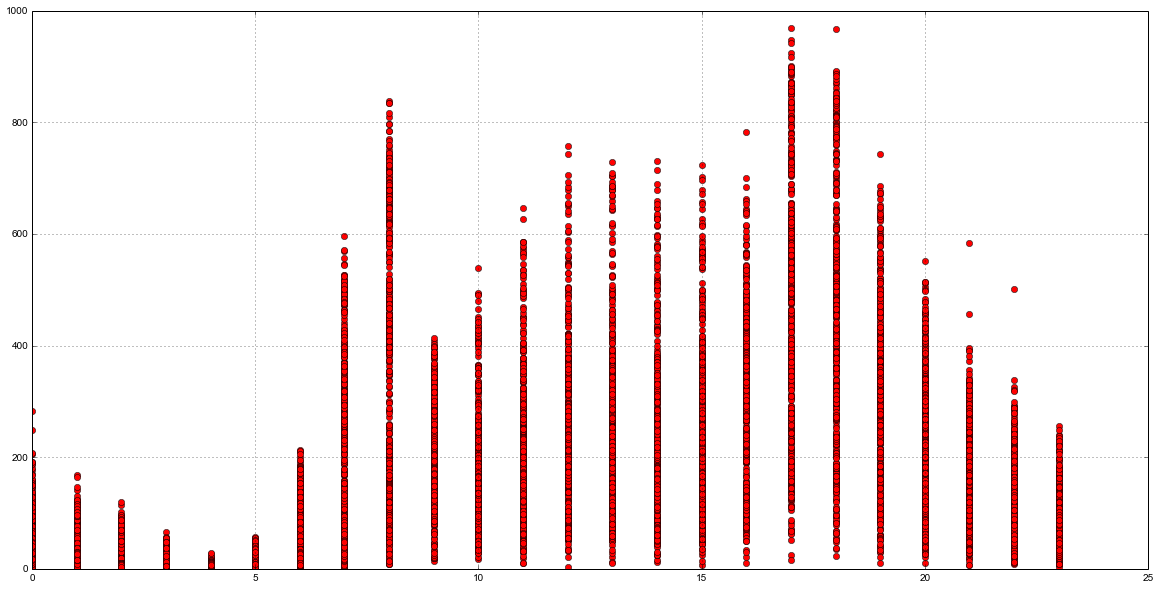

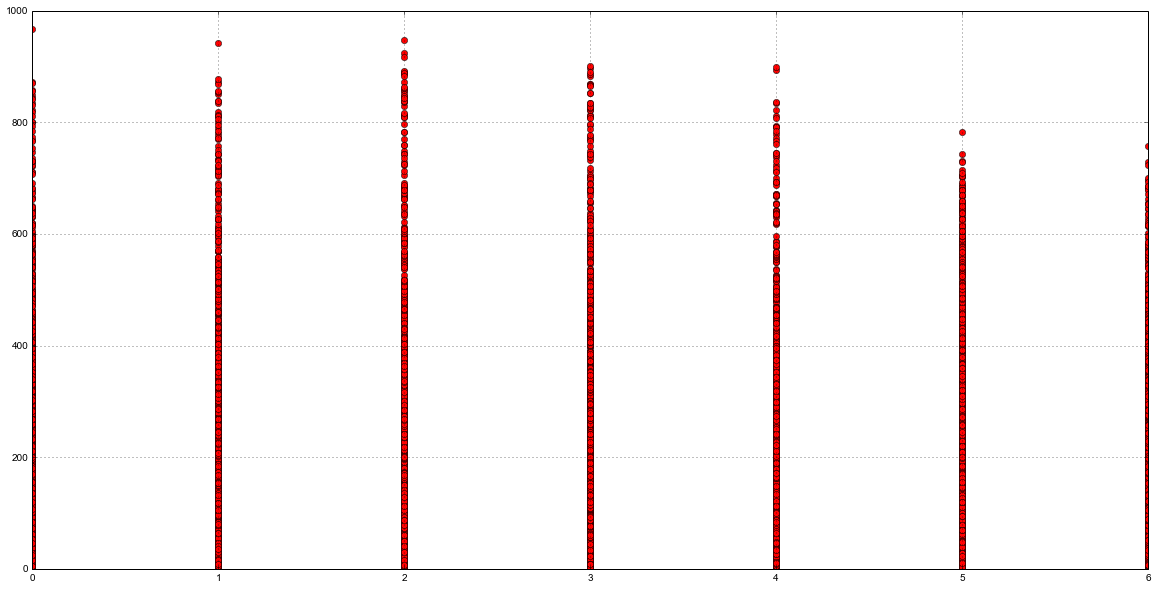

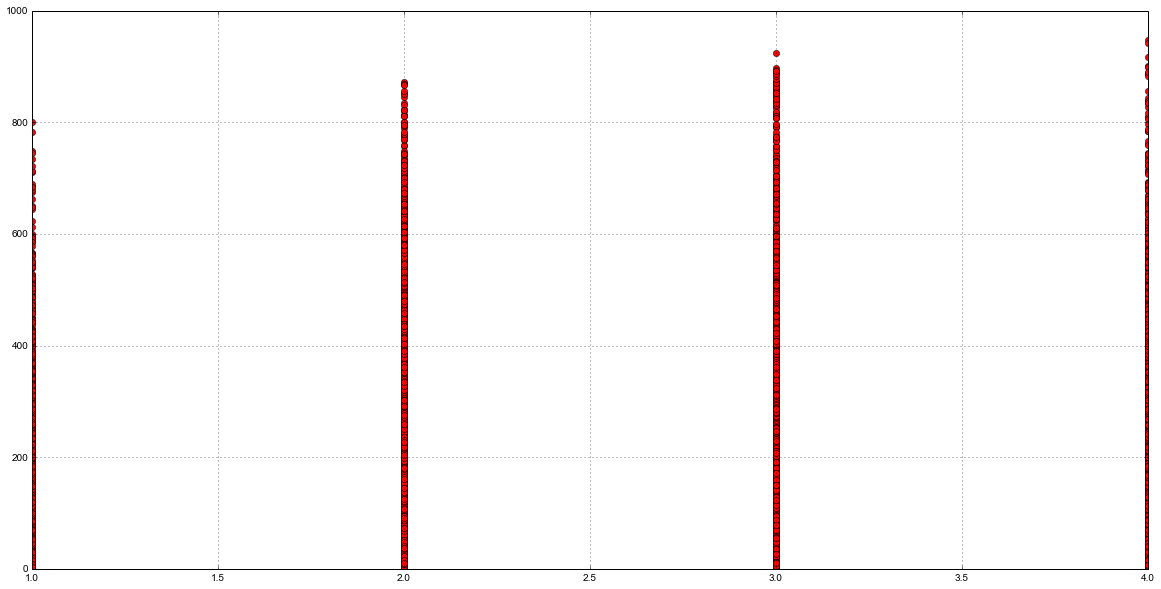

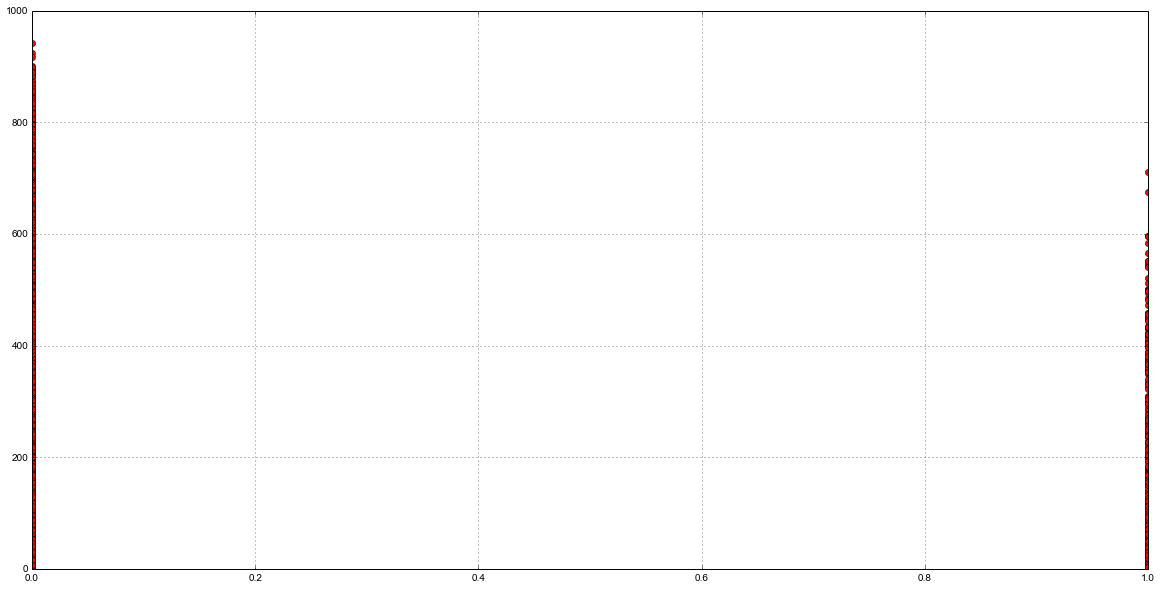

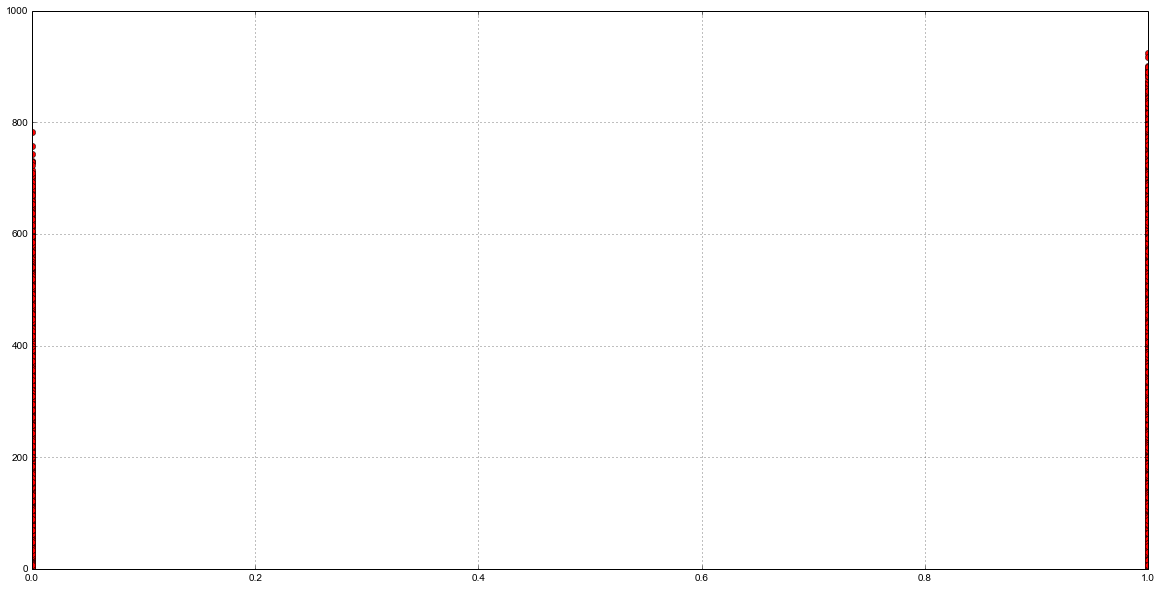

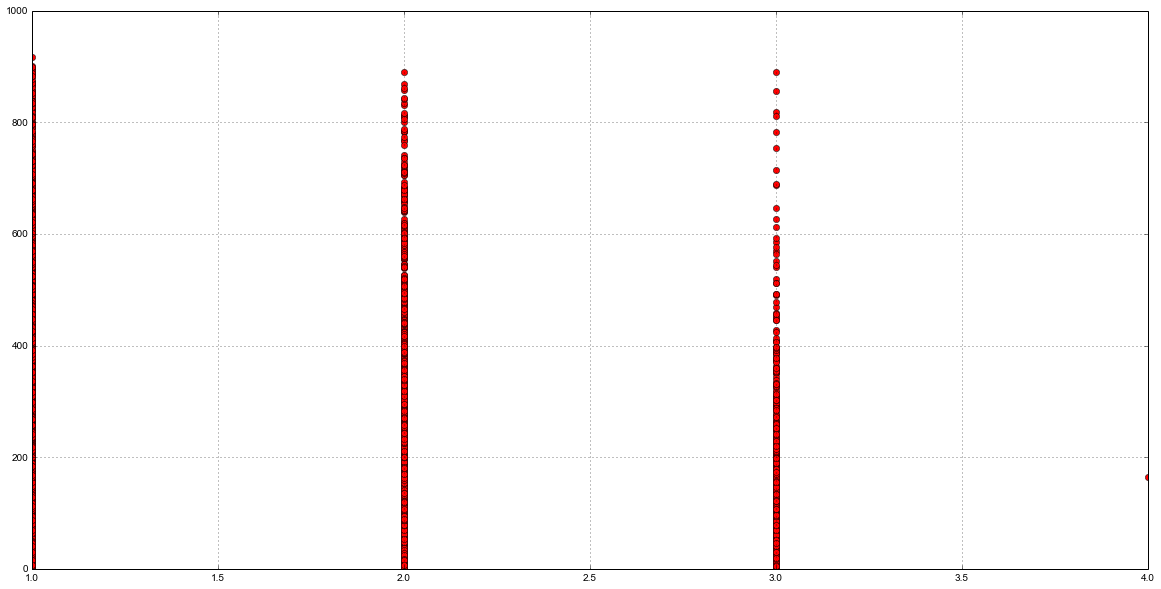

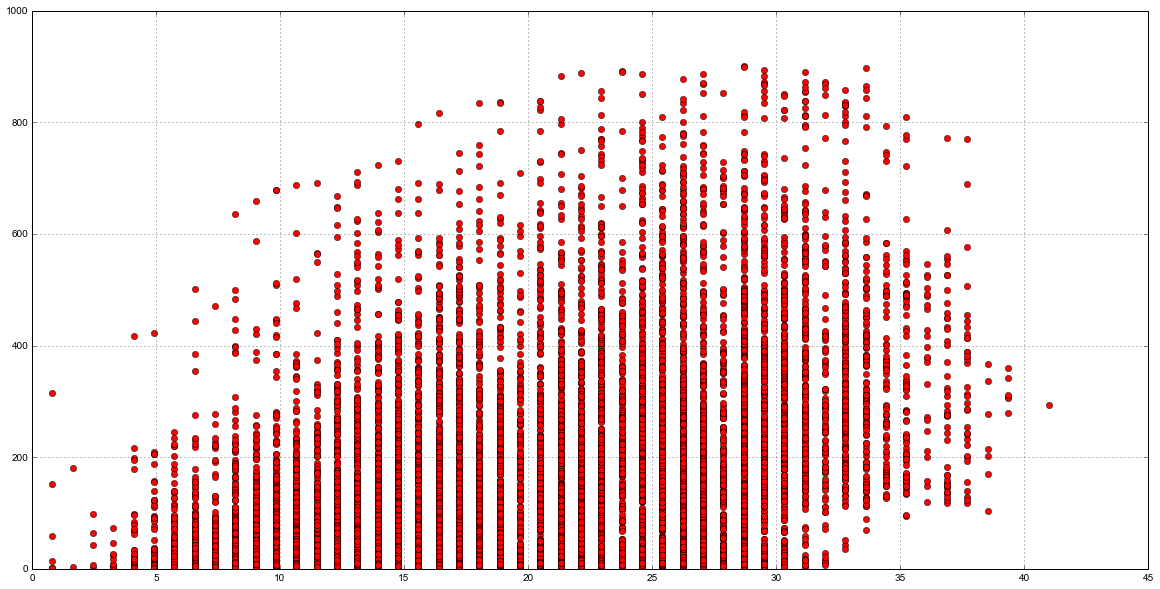

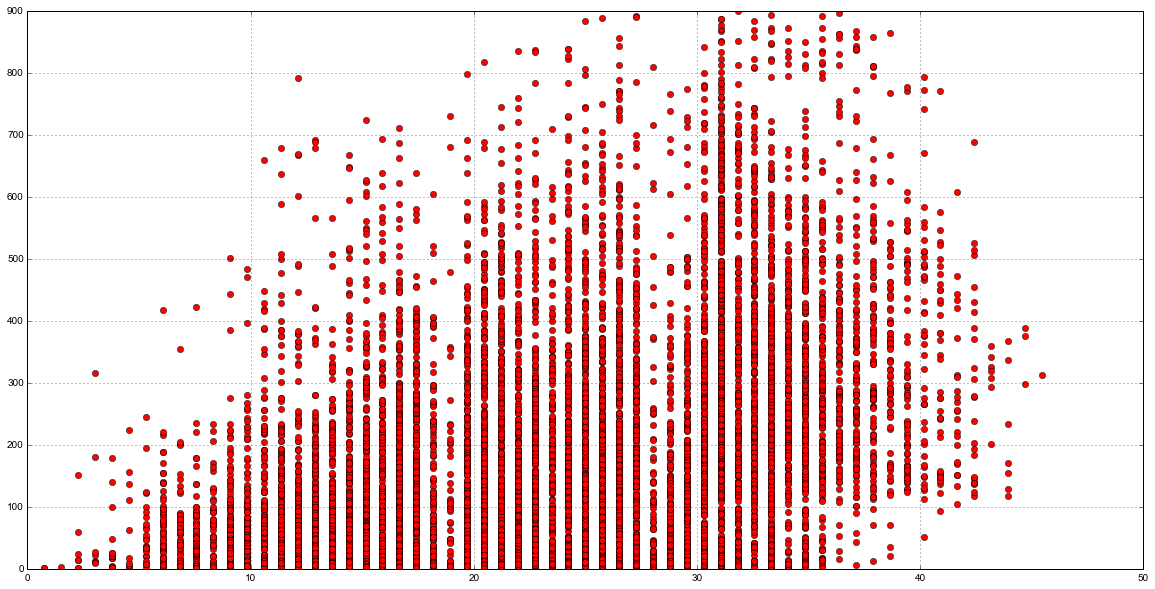

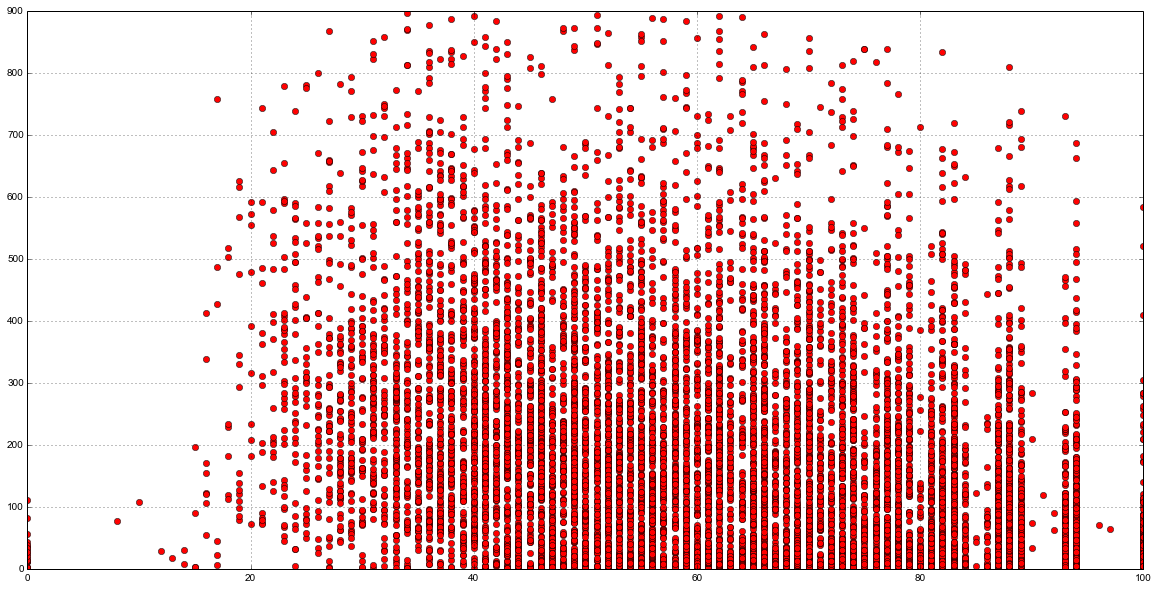

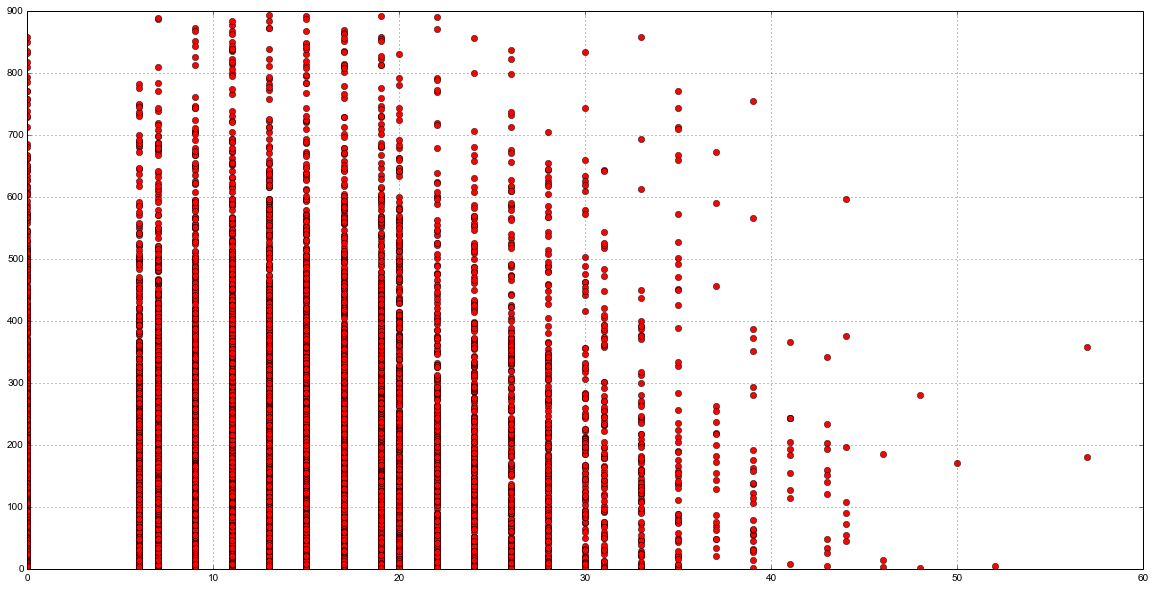

In [5]:
total_clean = 0.1
clean_per_features = total_clean / len(train_features[0])

for i in range(len(train_features[0])):  
    new_size = len(train_features) - clean_per_features
    while len(train_features) > new_size:
        lst = [x[i] for x in train_features]
        mean = np.array(lst).mean()
    
        norm = [abs(x-mean) for x in train_labels]
        index = norm.index(max(norm))

        del train_labels[index]
        del train_features[index]
        
    x_axis = [x[i] for x in train_features]
    y_axis = train_labels

    %matplotlib inline
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 10))
    plt.plot(x_axis, y_axis, 'ro', label='Positive')
    plt.grid()
    plt.show()

In [6]:
outliers_size = int(0.1 * len(train_labels))
new_size = len(train_labels) - outliers_size

while len(train_labels) > new_size:
    mean = np.array(train_labels).mean()
    
    norm = [abs(x-mean) for x in train_labels]
    index = norm.index(max(norm))
    
    del train_labels[index]
    del train_features[index]


In [7]:
from sklearn.cross_validation import train_test_split

train_f, test_f, train_l, test_l = train_test_split(train_features, train_labels, test_size=0.33)

from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(max_features=6, min_samples_split=15)
clf.fit(train_f, train_l)

predicted = clf.predict(test_f)

print clf.score(test_f, test_l)
print clf.feature_importances_

0.711585412484
[  1.68104748e-01   3.49738281e-03   3.81474304e-01   1.16455963e-05
   1.25818702e-02   1.31940248e-02   9.05530257e-02   3.31514042e-03
   3.26778825e-01   4.89034529e-04]


In [8]:
from sklearn.grid_search import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()

param_grid = {
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [2, 5, 10, 15, 20]
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_features, train_labels)
print CV_rfc.best_params_

{'max_features': 9, 'min_samples_split': 20}


In [9]:
import csv

test_data = []
with open('test.csv') as fin:
    reader = csv.reader(fin, delimiter=',')
    next(reader, None)
    for row in reader:
        test_data.append(row)

In [10]:
test_features = []

from dateutil import parser
import calendar

for item in test_data:
    features = []
    time = parser.parse(item[0])
    
    seconds_after_midnight = (time - time.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    hours_after_midnight = seconds_after_midnight // 3600
    day_of_week = time.weekday()
    
    features = features + [hours_after_midnight, day_of_week]
    features = features + [float(x) for x in item[1:]]
    test_features.append(features)
    
print test_features[0], len(test_features[0])

[0.0, 3, 1.0, 0.0, 1.0, 1.0, 10.66, 11.365, 56.0, 26.0027] 10


In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_features=7, min_samples_split=20, n_jobs=-1)
clf.fit(train_features, train_labels)

print clf.feature_importances_

test_predicted = clf.predict(test_features)

[  5.02566408e-01   9.24360318e-03   6.28068899e-02   1.91559751e-04
   6.54411970e-03   1.49667674e-02   1.04567609e-01   2.60979762e-01
   3.74634991e-02   6.69782440e-04]


In [12]:
result = []

marks = [x[0] for x in test_data]

with open('bicycle_predicted.csv', 'wb+') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['datetime', 'count'])
    for (x, y) in zip(marks, test_predicted):
        writer.writerow([x, int(round(y,0))])
    